<a href="https://colab.research.google.com/github/r0cketr1kky/COVID-19_X-Ray/blob/master/ResnetSmoothScoreCAMtrials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
#!/usr/bin/env python
"""flashtorch.utils

This module provides utility functions for image handling and tensor
transformation.

"""
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.transforms.functional as F

def load_image(image_path):
    """Loads image as a PIL RGB image.

        Args:
            - **image_path (str) - **: A path to the image

        Returns:
            An instance of PIL.Image.Image in RGB

    """

    return Image.open(image_path).convert('RGB')


def apply_transforms(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor

def apply_transforms_v0(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor()
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor


def denormalize(tensor):
    """Reverses the normalisation on a tensor.

    Performs a reverse operation on a tensor, so the pixel value range is
    between 0 and 1. Useful for when plotting a tensor into an image.

    Normalisation: (image - mean) / std
    Denormalisation: image * std + mean

    Args:
        tensor (torch.Tensor, dtype=torch.float32): Normalized image tensor

    Shape:
        Input: :math:`(N, C, H, W)`
        Output: :math:`(N, C, H, W)` (same shape as input)

    Return:
        torch.Tensor (torch.float32): Demornalised image tensor with pixel
            values between [0, 1]

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    denormalized = tensor.clone()

    for channel, mean, std in zip(denormalized[0], means, stds):
        channel.mul_(std).add_(mean)

    return denormalized


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0):
    """Standardizes and clips input tensor.

    Standardize the input tensor (mean = 0.0, std = 1.0), ensures std is 0.1
    and clips it to values between min/max (default: 0.0/1.0).

    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)

    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input

    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]

    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()
    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(0.1)
    clipped = standardized.add(0.5).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.

    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.

    Args:
        tensor (torch.Tensor, torch.float32): Image tensor

    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively

    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()


def visualize(input_, gradients, save_path=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """

    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    subplots = [
        ('Input image', [(input_, None, None)]),
        ('Saliency map across RGB channels', [(gradients, None, None)]),
        ('Overlay', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(16, 3))

    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)

        ax.set_title(title)
    if save_path is not None:
        plt.savefig(save_path)


def basic_visualize(input_, gradients, save_path=None, weight=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """
    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    subplots = [
        ('Saliency map across RGB channels', [(gradients, None, None)]),
        ('Overlay', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(4, 4))

    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)

    if save_path is not None:
        plt.savefig(save_path)


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'layer4'

    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision densenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features_12'
                target_layer_name = 'features_12_expand3x3'
                target_layer_name = 'features_12_expand3x3_activation'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_googlenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'inception5b'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_mobilenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_shufflenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'conv5'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_layer(arch, target_layer_name):
    """Find target layer to calculate CAM.

        : Args:
            - **arch - **: Self-defined architecture.
            - **target_layer_name - ** (str): Name of target class.

        : Return:
            - **target_layer - **: Found layer. This layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name.split('_') not in arch._modules.keys():
        raise Exception("Invalid target layer name.")
    target_layer = arch._modules[target_layer_name]
    return target_layer

In [0]:
'''
Part of code borrows from https://github.com/1Konny/gradcam_plus_plus-pytorch
'''

import torch

class BaseCAM(object):
    """ Base class for Class activation mapping.
        : Args
            - **model_dict -** : Dict. Has format as dict(type='vgg', arch=torchvision.models.vgg16(pretrained=True),
            layer_name='features',input_size=(224, 224)).
    """

    def __init__(self, model_dict):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        
        self.model_arch = model_dict['arch']
        self.model_arch.eval()
        #if torch.cuda.is_available():
        #  self.model_arch.cuda()
        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            #if torch.cuda.is_available():
            #  self.gradients['value'] = grad_output[0].cuda()
            
            self.gradients['value'] = grad_output[0]
            
            return None

        def forward_hook(module, input, output):
            #if torch.cuda.is_available():
            #  self.activations['value'] = output.cuda()
            self.activations['value'] = output
            
            return None

        if 'vgg' in model_type.lower():
            self.target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            self.target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            self.target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            self.target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            self.target_layer = find_squeezenet_layer(self.model_arch, layer_name)
        elif 'googlenet' in model_type.lower():
            self.target_layer = find_googlenet_layer(self.model_arch, layer_name)
        elif 'shufflenet' in model_type.lower():
            self.target_layer = find_shufflenet_layer(self.model_arch, layer_name)
        elif 'mobilenet' in model_type.lower():
            self.target_layer = find_mobilenet_layer(self.model_arch, layer_name)
        else:
            self.target_layer = find_layer(self.model_arch, layer_name)

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def forward(self, input, class_idx=None, retain_graph=False):
        return None

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [0]:
import torch
import torch.nn.functional as F


class ScoreCAM(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        #if torch.cuda.is_available():
        #  predicted_class= predicted_class.cuda()
        #  score = score.cuda()
        #  logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b, k, u, v = activations.size()
        
        score_saliency_map = torch.zeros((1, 1, h, w))

        #if torch.cuda.is_available():
        #  activations = activations.cuda()
        #  score_saliency_map = score_saliency_map.cuda()

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
              
              if saliency_map.max() == saliency_map.min():
                continue
              
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              output = self.model_arch(input * norm_saliency_map)
              output = F.softmax(output)
              score = output[0][predicted_class]

              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


In [0]:
traindir = "/gdrive/My Drive/chestct_scans/xray_dataset_covid19/train/"
validdir = "/gdrive/My Drive/chestct_scans/xray_dataset_covid19/validation/"
testdir = "/gdrive/My Drive/chestct_scans/xray_dataset_covid19/test/"

from torchvision import transforms, datasets, models
import torch
from torch import optim
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

In [6]:
import os
import pandas as pd
import numpy as np


categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

,category,n_train,n_valid,n_test
0,NORMAL,74,10,10
1,PNEUMONIA,74,10,10


Text(0.5, 1.0, 'Training Images by Category')

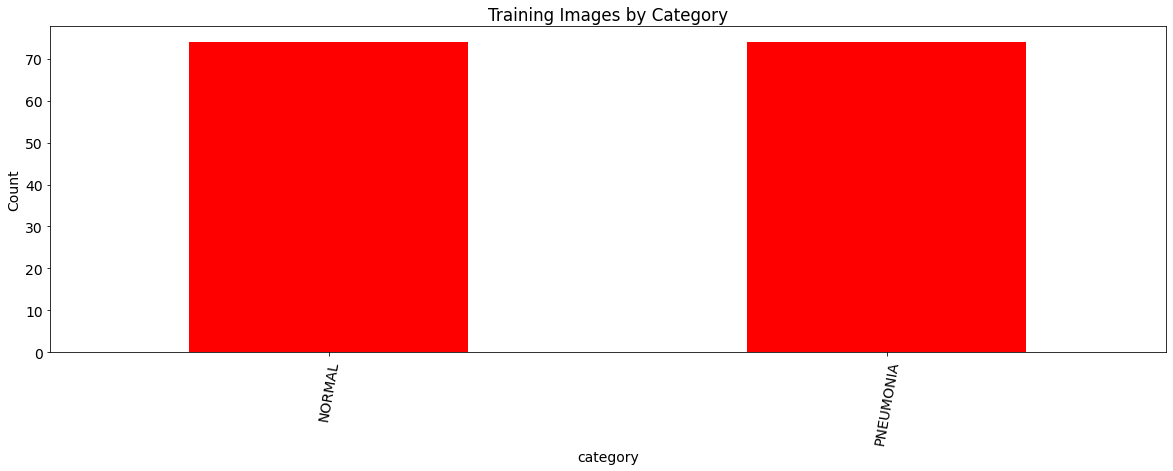

In [7]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [0]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [10]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

batch_size = 128

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [11]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 2 different classes.


2

In [0]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 2), nn.Softmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 2), nn.Softmax(dim=1))

    # Move to gpu and parallelize
    #if train_on_gpu:
    #    model = model.to('cuda')

    #if multi_gpu:
    #    model = nn.DataParallel(model)

    return model


In [0]:
#model = torch.load('/gdrive/My Drive/resnet50')

In [14]:
model = get_pretrained_model('resnet50')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'NORMAL'), (1, 'PNEUMONIA')]

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,623,042 total parameters.
1,115,010 training parameters.


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([512, 2048])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([2, 128])
torch.Size([2])


In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            #if train_on_gpu:
            #    data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    #if train_on_gpu:
                    #    data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [20]:
save_file_name = '/gdrive/My Drive/resnet50trial3-transfer-4.pt'


model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10)

torch.save(model, '/gdrive/My Drive/resnet50trial3')

Starting Training from Scratch.


Epoch: 1 	Training Loss: -0.5129 	Validation Loss: -0.5258
		Training Accuracy: 60.14%	 Validation Accuracy: 50.00%

Epoch: 3 	Training Loss: -0.5363 	Validation Loss: -0.5521
		Training Accuracy: 51.35%	 Validation Accuracy: 60.00%

Epoch: 5 	Training Loss: -0.5648 	Validation Loss: -0.5694
		Training Accuracy: 66.22%	 Validation Accuracy: 90.00%

Epoch: 7 	Training Loss: -0.6079 	Validation Loss: -0.5924
		Training Accuracy: 91.89%	 Validation Accuracy: 85.00%

Epoch: 9 	Training Loss: -0.6473 	Validation Loss: -0.6314
		Training Accuracy: 94.59%	 Validation Accuracy: 100.00%

Best epoch: 9 with loss: -0.63 and acc: 100.00%
475.57 total seconds elapsed. 52.84 seconds per epoch.


Text(0.5, 1.0, 'Training and Validation Losses')

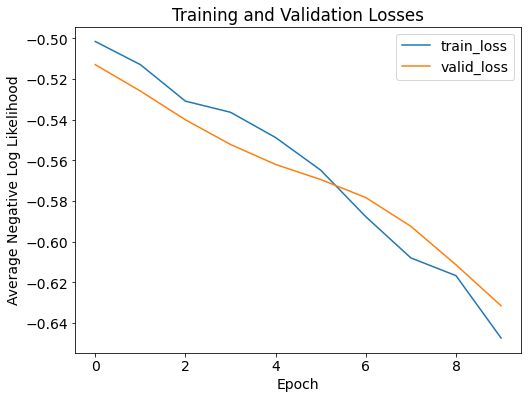

In [21]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

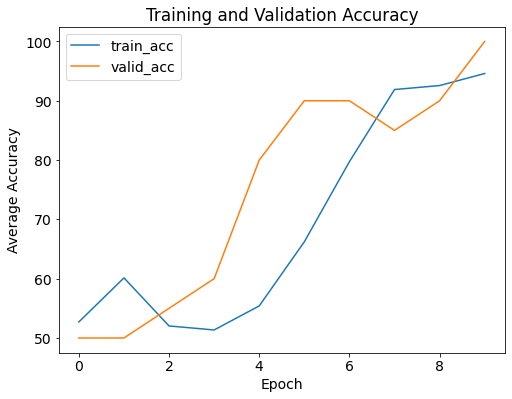

In [22]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
resnet = model.eval()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


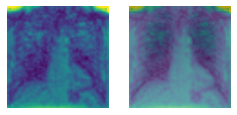

In [25]:
resnet_model_dict = dict(type='resnet50', arch=resnet, layer_name='layer1',input_size=(224, 224))
resnet_scorecam = ScoreCAM(resnet_model_dict)

input_image = load_image(validdir + 'PNEUMONIA/ryct.2020200034.fig5-day0.jpeg')
input_ = apply_transforms(input_image)
#print(input_)

#model_dict = dict(arch=model, layer_name='features_29', input_size=(224, 224))
  
scorecam_map = resnet_scorecam(input_)
basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


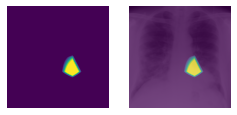

In [26]:
resnet_model_dict = dict(type='resnet50', arch=resnet, layer_name='layer4_bottleneck2_conv3',input_size=(224, 224))
resnet_scorecam = ScoreCAM(resnet_model_dict)

input_image = load_image(validdir + 'PNEUMONIA/ryct.2020200034.fig5-day0.jpeg')
input_ = apply_transforms(input_image)
#print(input_)

#model_dict = dict(arch=model, layer_name='features_29', input_size=(224, 224))
  
scorecam_map = resnet_scorecam(input_)
basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


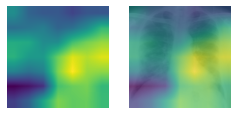

In [27]:
resnet_model_dict = dict(type='resnet50', arch=resnet, layer_name='layer4',input_size=(224, 224))
resnet_scorecam = ScoreCAM(resnet_model_dict)

input_image = load_image(validdir + 'PNEUMONIA/ryct.2020200034.fig5-day0.jpeg')
input_ = apply_transforms(input_image)
#print(input_)

#model_dict = dict(arch=model, layer_name='features_29', input_size=(224, 224))
  
scorecam_map = resnet_scorecam(input_)
basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu())

In [28]:
print(scorecam_map) 

tensor([[[[0.4905, 0.4905, 0.4905,  ..., 0.2702, 0.2702, 0.2702],
          [0.4905, 0.4905, 0.4905,  ..., 0.2702, 0.2702, 0.2702],
          [0.4905, 0.4905, 0.4905,  ..., 0.2702, 0.2702, 0.2702],
          ...,
          [0.1882, 0.1882, 0.1882,  ..., 0.6812, 0.6812, 0.6812],
          [0.1882, 0.1882, 0.1882,  ..., 0.6812, 0.6812, 0.6812],
          [0.1882, 0.1882, 0.1882,  ..., 0.6812, 0.6812, 0.6812]]]])


In [0]:
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', '/_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', '/_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', '/_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    #pretrained_model = model
    return (original_image,
            prep_img,
            target_class)

In [0]:
import torch
import torch.nn as nn


class BaseProp(object):
    """
        Base class for backpropagation.
    """

    def __init__(self, model):
        """Init
        # Arguments:
            model: torchvision.models. A pretrained model.
            handle: list. Handle list that register a hook function.
            relu_outputs: list. Forward output after relu.
        """
        self.model = model
        self.handle = []
        self.relu_outputs = []

    def _register_conv_hook(self):

        """
            Register hook function to save gradient w.r.t input image.
        """

        def _record_gradients(module, grad_in, grad_out):
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and module.in_channels == 3:
                backward_handle = module.register_backward_hook(_record_gradients)
                self.handle.append(backward_handle)

    def _register_relu_hooks(self):

        """
            Register hook function to save forward and backward relu result.
        """

        # Save forward propagation output of the ReLU layer
        def _record_output(module, input_, output):
            self.relu_outputs.append(output)

        def _clip_gradients(module, grad_in, grad_out):
            # keep positive forward propagation output
            relu_output = self.relu_outputs.pop()
            relu_output[relu_output > 0] = 1

            # keep positive backward propagation gradient
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)

            # generate modified guided gradient
            modified_grad_out = positive_grad_out * relu_output

            return (modified_grad_out, )

        for _, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                forward_handle = module.register_forward_hook(_record_output)
                backward_handle = module.register_backward_hook(_clip_gradients)
                self.handle.append(forward_handle)
                self.handle.append(backward_handle)

In [0]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [0]:
class Backprop(BaseProp):

    """ Generates vanilla or guided backprop gradients of a target class output w.r.t. an input image.
        # Arguments:
            model: torchvision.models. A pretrained model.
            guided: bool. If True, perform guided backpropagation. Defaults to False.
        # Return:
            Backprop Class.
    """

    def __init__(self, model, guided=False):
        super().__init__(model)
        self.model.eval()
        self.guided = guided
        self.gradients = None
        self._register_conv_hook()

    def calculate_gradients(self,
                            input_,
                            target_class=None,
                            take_max=False,
                            use_gpu=False):

        """ Calculate gradient.
            # Arguments
                input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
                target_class: int. Index of target class. Default to None and use the prediction result as target class.
                take_max: bool. Take the maximum across colour channels. Defaults to False.
                use_gpu. bool. Use GPU or not. Defaults to False.
            # Return:
                Gradient (torch.Tensor) with shape (C, H, W). If take max is True, with shape (1, H, W).
        """

        if self.guided:
            self._register_relu_hooks()

        # Create a empty tensor to save gradients
        self.gradients = torch.zeros(input_.shape)

        output = self.model(input_)

        self.model.zero_grad()

        if output.shape == torch.Size([1]):
            target = None
        else:
            pred_class = output.argmax().item()

            # Create a Tensor with zero elements, set the element at pred class index to be 1
            target = torch.zeros(output.shape)

            # If target class is None, calculate gradient of predicted class.
            if target_class is None:
                target[0][pred_class] = 1
            else:
                target[0][target_class] = 1

            
        # Calculate gradients w.r.t. input image
        output.backward(gradient=target)

        gradients = self.gradients.detach().cpu()[0]

        if take_max:
            gradients = gradients.max(dim=0, keepdim=True)[0]

        for module in self.handle:
            module.remove()
        gradients = gradients.numpy()
        return gradients

In [33]:
import numpy as np

from torch.autograd import Variable
import torch

from PIL import Image

# from guided_backprop import GuidedBackprop  # To use with guided backprop


def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):
    """
        Generates smooth gradients of given Backprop type. You can use this with both vanilla
        and guided backprop
    Args:
        Backprop (class): Backprop type
        prep_img (torch Variable): preprocessed image
        target_class (int): target class of imagenet
        param_n (int): Amount of images used to smooth gradient
        param_sigma_multiplier (int): Sigma multiplier when calculating std of noise
    """
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    for x in range(param_n):
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = Backprop.calculate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad


# Get params 
original_image =  Image.open('/gdrive/My Drive/chestct_scans/xray_dataset_covid19/validation/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg')
prep_img = preprocess_image(original_image)
target_class = 1

#VBP = VanillaBackprop(model)
GBP = Backprop(model, guided=True)  # if you want to use GBP dont forget to
# change the parametre in generate_smooth_grad

param_n = 50
param_sigma_multiplier = 4
smooth_grad = generate_smooth_grad(GBP,  # ^This parameter
                                   prep_img,
                                   target_class,
                                   param_n,
                                   param_sigma_multiplier)

    # Save colored gradients
#save_gradient_images(smooth_grad, validdir + '_SmoothGrad_color')
    # Convert to grayscale
grayscale_smooth_grad = convert_to_grayscale(smooth_grad)
print(grayscale_smooth_grad)
    # Save grayscale gradients
#save_gradient_images(grayscale_smooth_grad, validdir + '_SmoothGrad_gray')
print('Smooth grad completed')

could not transform PIL_img to a PIL Image object. Please check input.
[[[0.44047403 0.15025461 0.59823907 ... 0.05660666 0.042472   0.00758473]
  [0.55393815 0.74098546 0.48790478 ... 0.08009078 0.08808841 0.0628747 ]
  [0.66855238 1.         0.78283931 ... 0.1002439  0.0787401  0.00838249]
  ...
  [0.1015757  0.15255389 0.25617858 ... 0.05309342 0.06641462 0.03214827]
  [0.02801429 0.06564498 0.07850883 ... 0.04256931 0.02192077 0.05665576]
  [0.02225575 0.09302892 0.03699689 ... 0.02684161 0.04670684 0.05316452]]]
Smooth grad completed


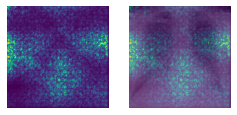

In [34]:
ans = np.multiply(scorecam_map, grayscale_smooth_grad)
basic_visualize(input_.cpu(), ans.type(torch.FloatTensor).cpu())